# Agent 에 메모리(memory) 추가

현재 챗봇은 과거 상호작용을 스스로 기억할 수 없어 일관된 다중 턴 대화를 진행하는 데 제한이 있습니다. 

이번 튜토리얼에서는 이를 해결하기 위해 **memory** 를 추가합니다.

**참고**

이번에는 pre-built 되어있는 `ToolNode` 와 `tools_condition` 을 활용합니다.

1. [ToolNode](https://langchain-ai.github.io/langgraph/reference/prebuilt/#langgraph.prebuilt.tool_node.ToolNode): 도구 호출을 위한 노드
2. [tools_condition](https://langchain-ai.github.io/langgraph/reference/prebuilt/#langgraph.prebuilt.tool_node.tools_condition): 도구 호출 여부에 따른 조건 분기


우리의 챗봇은 이제 도구를 사용하여 사용자 질문에 답할 수 있지만, 이전 상호작용의 **context**를 기억하지 못합니다. 이는 멀티턴(multi-turn) 대화를 진행하는 능력을 제한합니다.

`LangGraph`는 **persistent checkpointing** 을 통해 이 문제를 해결합니다. 

그래프를 컴파일할 때 `checkpointer`를 제공하고 그래프를 호출할 때 `thread_id`를 제공하면, `LangGraph`는 각 단계 후 **상태를 자동으로 저장** 합니다. 동일한 `thread_id`를 사용하여 그래프를 다시 호출하면, 그래프는 저장된 상태를 로드하여 챗봇이 이전에 중단한 지점에서 대화를 이어갈 수 있게 합니다.

**checkpointing** 는 LangChain 의 메모리 기능보다 훨씬 강력합니다. (아마 이 튜토리얼을 완수하면 자연스럽게 이를 확인할 수 있습니다.)

In [1]:
# API 키를 환경변수로 관리하기 위한 설정 파일
from dotenv import load_dotenv

# API 키 정보 로드
load_dotenv()

True

하지만 너무 앞서 나가기 전에, 멀티턴(multi-turn) 대화를 가능하게 하기 위해 **checkpointing**을 추가해 보도록 하겠습니다.

`MemorySaver` checkpointer를 생성합니다.

In [2]:
from langgraph.checkpoint.memory import MemorySaver

# 메모리 저장소 생성
memory = MemorySaver()

**참고**

이번 튜토리얼에서는 `in-memory checkpointer` 를 사용합니다. 

하지만, 프로덕션 단계에서는 이를 `SqliteSaver` 또는 `PostgresSaver` 로 변경하고 자체 DB에 연결할 수 있습니다. 

In [ ]:
from typing import Annotated
from typing_extensions import TypedDict
from langchain_openai import ChatOpenAI
from langchain_teddynote.tools.tavily import TavilySearch
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
# from langgraph.prebuilt import ToolNode, tools_condition  # 제거 또는 대체 필요
from langchain_core.tools import BaseTool
########## 1. 상태 정의 ##########
# 상태 정의
class State(TypedDict):
    # 메시지 목록 주석 추가
    messages: Annotated[list, add_messages]

########## 2. 도구 정의 및 바인딩 ##########
# 도구 초기화
tool = TavilySearch(max_results=3)
tools = [tool]

# LLM 초기화
llm = ChatOpenAI(model="gpt-4o-mini")

# 도구와 LLM 결합
llm_with_tools = llm.bind_tools(tools)

########## 3. 노드 추가 ##########
# 챗봇 함수 정의
def chatbot(state: State):
    # 메시지 호출 및 반환
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

# 상태 그래프 생성
graph_builder = StateGraph(State)

# 챗봇 노드만 추가
graph_builder.add_node("chatbot", chatbot)

# 조건부 엣지: 항상 END로 이동 (도구 호출 없음)
def tools_condition(state: State):
    return END

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)

########## 4. 엣지 추가 ##########

# START > chatbot
graph_builder.add_edge(START, "chatbot")

# chatbot > END
graph_builder.add_edge("chatbot", END)

마지막으로, 제공된 `checkpointer`를 사용하여 그래프를 컴파일합니다.

In [14]:
from typing import Annotated
from typing_extensions import TypedDict
from langchain_openai import ChatOpenAI
from langchain_teddynote.tools.tavily import TavilySearch
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.checkpoint.memory import MemorySaver

class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

tool = TavilySearch(max_results=2)
tools = [tool]
llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)

# 조건부 엣지: 항상 END로 이동 (도구 호출 없음)
def tools_condition(state: State):
    return END

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)

graph_builder.set_entry_point("chatbot")
memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)

그래프의 연결성은 `LangGraph-Agent` 와 동일합니다.

단지, 이번에 추가된 것은 그래프가 각 노드를 처리하면서 `State`를 체크포인트하는 것뿐입니다.

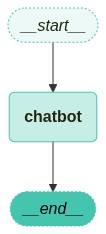

In [15]:
from langchain_teddynote.graphs import visualize_graph

# 그래프 시각화
visualize_graph(graph)